In [36]:
# import the necessary libraries
import numpy as np
import pandas as pd
import requests
import zipfile
import time
import math
import folium
from folium import plugins
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Battle of the Neighbourhoods : The Hunt for Hipsters

# 1. Introduction / Business Problem

My partner is a jewellery designer/maker, with a successful shop in a trendy part of London.  She has expressed an interest in opening a second shop, and her usual strategy for this might be to go do some market research.  Rather than simply ask the coolest people we know, I’d like to use data science to identify an appropriate location.   

The question is this: can we work out which are the hippest areas in London, and the areas that are on the verge of becoming hip?  And given that where would be a good place to open a cool jewelry shop?

This approach could apply to anyone interested in opening an independent store or brand in London, and if successful could by applied to any city for which we have the appropriate data.

# 2. Data

We'll break this down into 2 components: quantifying trendiness into clusters, and finding competitive advantage.

To quantify trendiness we'll explore different options, among them identifying whether there are a large number of chain (non-independent) stores in the area, or stores with particular or unusual categories.  We'll look at the frequency and density of specific category types such as record stores and coffee shops.

To find competitive advantage, we'll look at details of the specific jewelry shops, including rating and price.  Consideration should be given to the number of total shops and restaurants in the area (which would generate more footfall and be a positive influence), as well as other jewellery shops (which would mean more competition and be a negative influence).

The data we'll need includes:

* **Geocoding** - to identify the specific locations
* **Foursquare API** - to identify the qualifying places (jewelry stores, restaurants etc.) and essential details around them


## 2.2. Geocoding

[Geonames.org](https://www.geonames.org/) is a fantastic free resource that publishes geocoded names and their latitudes/longitudes many countries around the world.  The GeoNames geographical database is available for download free of charge under a creative commons attribution license.  The resource includes an explicit accuracy for the latitude/longitude, which will be useful for filtering out bad/inaccurate/duplicate data.

Below is a sample of the resulting data.  Note the available Latitude/Longitude, and the Accuracy record.

In [2]:
# download file from geoname
url = 'http://download.geonames.org/export/zip/GB.zip'
zipname = 'GB.zip'
r = requests.get(url)

with open(zipname, 'wb') as f:
    f.write(r.content)

# extract file from zip
with zipfile.ZipFile(zipname, 'r') as f:
    f.extractall()

# read from csv
columns = ['Countrycode','Postalcode','Placename','Adminname1','Admincode1','Adminname2','Admincode2','Adminname3','Admincode3','Latitude','Longitude','Accuracy']
gb = pd.read_csv('GB.txt', sep='\t', header=None, names=columns)
gb.head(5)

,Countrycode,Postalcode,Placename,Adminname1,Admincode1,Adminname2,Admincode2,Adminname3,Admincode3,Latitude,Longitude,Accuracy
0,GB,DN14,Goole,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7167,-0.8667,4.0
1,GB,DN14,Pollington,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.6709,-1.0724,4.0
2,GB,DN14,Faxfleet,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7067,-0.6939,4.0
3,GB,DN14,Laxton,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7167,-0.8000,4.0
4,GB,DN14,Old Goole,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7125,-0.8909,3.0



According to the documentation, 'Accuracy' is defined as below:

```
Accuracy is an integer, the higher the better :
1 : estimated as average from numerically neigbouring postal codes
3 : same postal code, other name
4 : place name from geonames db
6 : postal code area centroid
```

Consequently we'll want to limit ourselves to codes with an Accuracy of greater or equal to 3 (averages of neighboring postal codes isn't useful).  And because we're going to be using the Latitude/Longitude, we'll remove duplicate records of that and use only the first name.  Postalcode will be tricky to use as it bridges Placenames, but we'll want to keep it around for reference and collapse it into a single column joined by a comma.

Finally, we'll be limiting ourselves to Greater London.  

Below is a resulting sample of the data we'll use:

In [3]:
# pick only greater london, locations with an accuracy 3
ldn = gb[(gb['Adminname2']=='Greater London') & (gb['Accuracy'] >= 3.0)].copy()

# remove unnecessary columns
ldn.drop(['Countrycode', 'Adminname1', 'Admincode1', 'Adminname2', 'Admincode2', 'Adminname3', 'Admincode3', 'Accuracy'], axis='columns', inplace=True)

# get rid of duplicated lat/lon for a postcode, as we'll be using that dimension as a location
ldn.drop_duplicates(subset=['Latitude', 'Longitude', 'Postalcode'], inplace=True)

# merge postcodes for duplicate lat/lon
ldn = ldn.groupby(['Latitude','Longitude']).agg({'Placename':'first', 'Postalcode': ','.join }).reset_index()
ldn.head(5)

,Latitude,Longitude,Placename,Postalcode
0,51.3133,0.0343,Biggin Hill,TN16
1,51.3148,-0.1570,Hooley,CR5
2,51.3192,0.0712,Cudham,TN14
3,51.3200,-0.1409,Coulsdon,CR5
4,51.3264,-0.1011,Kenley,CR8


In [4]:
print('There are {} Places we will evaluate in London'.format(len(ldn.index)))

There are 468 Places we will evaluate in London


A review of a map of London with the locations marked at a radius of 1000m exposes the amount of overlapping areas and the high coverage for central London.  This should be sufficient for our evaluation.

In [5]:
# create map of London using latitude and longitude values, with a 1000m radius circle
latitude, longitude = ldn.mean()

map_ldn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, place in zip(ldn['Latitude'], ldn['Longitude'], ldn['Placename']):
    label = folium.Popup(place, parse_html=True)
    folium.Circle(
        [lat, lng],
        1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ldn)
   
map_ldn.save('map_ldn.html')
map_ldn

## 2.2. Foursquare API

We will retrieve both the places and necessary details from the Foursquare API.  We'll get the precise location and category of the shop, as well as details such as price and rating where necessary.  Some of these calls will be necessarily premium calls, so to keep ourselves within the boundaries of free usage we'll limit them.

When using the search and explore endpoints the Foursquare API will naturally constrain the responses, presumably to keep people from scraping/farming locations.  We'll need to keep this in mind, as it means that our results will not be "complete" for a given radius.

In [6]:
CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

We'll begin by retrieving the full list of categories from Foursquare and identifying which of them corresponds to jewelry (note in the UK this is spelled "jewellery").

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                )
#categories = pd.DataFrame(requests.get(url).json()['response']['categories'])
cat_response = requests.get(url).json()['response']

# function to extract nested categories from FS response
def get_subcats(catlist, catref):
    if len(catref['categories']) > 0:
        for cat in catref['categories']:
            get_subcats(catlist, cat) 
    else:
        return catlist.append({'id': catref['id'], 'name': catref['name']})

# build the category list from foursquare    
cat_list = []
get_subcats(cat_list, cat_response)

cats = pd.DataFrame(cat_list)

cats[cats['name'].str.contains('Jewel')]

,id,name
746,4bf58dd8d48988d111951735,Jewelry Store


We want to focus on a specific types of venues, and the Foursquare API allows us to break things down into category "sections": shops, food, drinks, coffee, arts.  We'll make separate calls for each of these venue sections and collect the relavant details.  Although this may not get us everything, narrowing the search on sections will get us significantly more options.

Then we'll grab all the Jewelry Shop category venues in London exclusively.  Below is a sample of these stores, and a heatmap of all the stores across London.

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# function to grab venues from foursquare, re-usable across categories and sections
def getNearbyVenues(placenames, latitudes, longitudes, radius=800, categories=[], section=None):
    
    total_calls = 0
    total_results = 0
    total_projected_calls = 0
    venues_list=[]
    
    start = time.time()

    for place, lat, lng in zip(placenames, latitudes, longitudes):

        offset = 0
        max_results = 100
        
        # loop through the number of offsets until you grab all the data down
        while(offset < max_results):
            
            retry = 0
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                offset)
            
            if len(categories) > 0:
                url = url + '&categoryId=' + ','.join(categories)
            if section is not None:
                url = url + '&section=' + section
            
            total_calls = total_calls + 1
            results = requests.get(url).json()
    
            # ok response code, shift up the offset     
            if(results['meta']['code'] == 200):
                # return only relevant information for each nearby venue
                for v in results["response"]['groups'][0]['items']:

                    venues_list.append([
                        place, 
                        lat, 
                        lng,
                        v['venue']['id'], 
                        v['venue']['name'], 
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['location']['distance'],  
                        '|'.join(list(map(lambda x: x['name'], v['venue']['categories'])))])
                    
                max_results = results["response"]['totalResults']

                offset = offset + LIMIT
                
            # failed, need to retry at least 5 times
            elif(retry <=5):
                retry = retry +1
                #print("Error in fetch record for [{}]: retry {} in 2s".format(place, retry))
                time.sleep(2)

            # give up on this call
            else:
                #print("Unable to fetch record for [{}]".format(place)) 
                offset = 100000000  # give up after 5 tries
            
        total_results = total_results + max_results
        total_projected_calls = total_projected_calls + math.ceil(max_results/LIMIT)


    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Placename',
                'Latitude', 
                'Longitude',
                'Venue ID',
                'Venue',
                'Venue Latitude',
                'Venue Longitude',
                'Distance',
                'Venue Categories']

    end = time.time()
    #print('====================')
    #print('Radius        \t{}'.format(radius))
    #print('Calls to API: \t{}'.format(total_calls))
    #print('Calls Proj.:  \t{}'.format(total_projected_calls))
    #print('Places:       \t{}'.format(placenames.size))
    #print('Results:      \t{}'.format(total_results))
    #print('Time:         \t{}s'.format(end - start))
    #print('====================')

    return(nearby_venues)

In [9]:
# get list of shops
shops = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='shops'
                        )                        

In [10]:
# get list of coffee
coffee = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='coffee'
                        )

In [11]:
# get list of food
food = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='food'
                        )

In [12]:
# get list of drinks
drinks = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='drinks'
                        )

In [13]:
# get list of arts
arts = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='arts'
                        )


In [14]:
#get list of sights
sights = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='sights'
                        )


In [15]:
#get list of jewelry shops
jewels = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                categories=['4bf58dd8d48988d111951735']
                        )

In [16]:

# build list of each category (remove all duplicated venue IDs as these are the unique records)
shops_unique = shops.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

coffee_unique = coffee.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

food_unique = food.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

drinks_unique = drinks.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

arts_unique = arts.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

sights_unique = sights.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

jewels_unique = jewels.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)

In [17]:
jewels_unique.head()

,Placename,Latitude,Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Distance,Venue Categories
0,Warren Street,51.5136,-0.1498,4ac518eff964a52063ad20e3,Grays Antiques,51.513622,-0.148756,72,Antique Shop
1,Mayfair,51.5095,-0.1490,4ac518eff964a52066ad20e3,Montblanc Boutique,51.508787,-0.140840,570,Jewelry Store
2,Soho,51.5144,-0.1354,4ac518eff964a5208aad20e3,Storm,51.513183,-0.138767,269,Jewelry Store
3,Mayfair,51.5095,-0.1490,4ac518f0f964a520aaad20e3,Tiffany & Co.,51.509579,-0.141305,533,Jewelry Store
4,Oxford Circus,51.5154,-0.1414,4ac518f0f964a520c9ad20e3,H. Samuel,51.515108,-0.143251,132,Jewelry Store


In [18]:

# create map of London using latitude and longitude values
map_jewels = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, venue in zip(jewels_unique['Venue Latitude'], jewels_unique['Venue Longitude'], jewels_unique['Venue']):
    label = folium.Popup(venue, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill_color='#3db7e4',
        fill_opacity=0.3,
        parse_html=False).add_to(map_jewels)
   

# plot heatmap of jewelry stores
map_jewels.add_child(plugins.HeatMap(jewels_unique[['Venue Latitude', 'Venue Longitude']].values.tolist(), radius=20))
map_jewels

# 3. Methodology

As our interest is in finding the most interesting areas in London, we will use an unstructured approach, and after some initial exploratory work we will apply clustering strategies to the data, with the aim of uncovering patterns that we'll be able to use.

## 3.1. Exploratory Analysis

There are some basic principles of being a hipster, that we should be able to reflect in our preparation.

1. Chain stores are bad.  Be they coffee shops, book stores or otherwise, if it's a major brand (with few exceptions) then they should be avoided.
2. Funky independent shops are good.  Particularly those of a specific type, such as record stores or organic markets.
3. Variety is important.  The more options for shopping, food and drink, the better.
4. Don't forget culture.  An area that has an interest beyond consumerism is cool, so arts and sights are key.

Let's begin by looking at the data and seeing whether we can extract features from it.

### 3.1.1. Venue Frequency

As a possible metric for understanding whether a given venue is a chain, we'll look at the occurrence of the venue with the same name throughout London.  We want to easily identify the difference between actual independent stores, stores that might have 2-3 franchises across the city, and massive chains.  We want to severely penalise the latter.

We'll begin by looking at venues in the following Foursquare "sections": Shops, Coffee, Food, and Drinks.


In [19]:
# add the venue frequency and venue frequency sqared to shops, coffee, food, drinks
shops_final = shops.merge(\
    shops_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
shops_final['Venue Frequency Sq'] = shops_final['Venue Frequency']**2

coffee_final = coffee.merge(\
    coffee_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
coffee_final['Venue Frequency Sq'] = coffee_final['Venue Frequency']**2

food_final = food.merge(\
    food_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
food_final['Venue Frequency Sq'] = food_final['Venue Frequency']**2

drinks_final = drinks.merge(\
    drinks_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
drinks_final['Venue Frequency Sq'] = drinks_final['Venue Frequency']**2

#### Shops

Looking at the frequency distribution of all venues in the Shops group (focusing on incidence > 2), we can see a fairly high incidence of chains.  And if we look at the shops themselves we note that there are quite a few grocery store chains as well as other usual suspects.  Note that there are some cases where a venue has a different category, but looking at the available samples these are acceptable categorizations and not an error.

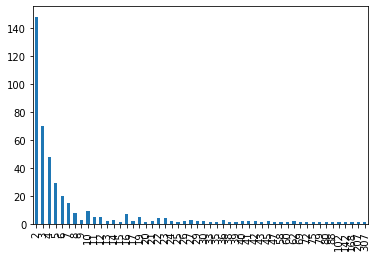

In [20]:
# plot the frequency distribution of shops
fig, ax = plt.subplots()
shops_unique.groupby('Venue')['Venue ID']\
    .agg(['count'])['count']\
    .value_counts()[1:]\
    .sort_index()\
    .plot(ax=ax, kind='bar')

In [21]:
# print sample of shops sorted by frequency
shops_unique.merge(shops_unique.groupby('Venue')['Venue ID'].agg(['count']), on='Venue')\
    .groupby(['Venue', 'Venue Categories'])['count']\
    .first().sort_values(ascending=False)\
    .head(20)

Venue               Venue Categories 
Tesco Express       Grocery Store        307
Sainsbury's Local   Convenience Store    207
                    Supermarket          207
                    Grocery Store        207
Boots               Pharmacy             168
Co-op Food          Grocery Store        142
Paddy Power         Betting Shop         102
WHSmith             Bookstore             88
                    Stationery Store      88
Carphone Warehouse  Mobile Phone Shop     80
Superdrug           Cosmetics Shop        79
                    Pharmacy              79
Iceland             Grocery Store         75
Sainsbury's         Supermarket           72
                    Grocery Store         72
Lidl                Discount Store        69
                    Supermarket           69
M&S Simply Food     Grocery Store         62
                    Convenience Store     62
                    Food & Drink Shop     62
Name: count, dtype: int64

#### Coffee

Next we'll look at venues in the Coffee group.  These have a less dramatic frequency curve, but are there are still quite a few chains of reasonable size.  The ubiquitous Starbucks is present, although not at the top of the list.

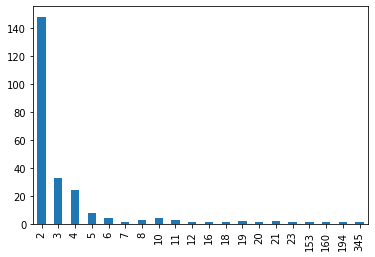

In [22]:
# plot the frequency distribution of coffee
fig, ax = plt.subplots()
coffee_unique.groupby('Venue')['Venue ID']\
    .agg(['count'])['count']\
    .value_counts()[1:]\
    .sort_index()\
    .plot(ax=ax, kind='bar')

In [23]:
# print sample of coffee sorted by frequency
coffee_unique.merge(coffee_unique.groupby('Venue')['Venue ID'].agg(['count']), on='Venue')\
    .groupby(['Venue', 'Venue Categories'])['count']\
    .first().sort_values(ascending=False)\
    .head(20)

Venue               Venue Categories
Costa Coffee        Coffee Shop         345
Starbucks           Coffee Shop         194
Pret A Manger       Coffee Shop         160
                    Sandwich Place      160
Caffè Nero          Coffee Shop         153
JOE & THE JUICE     Juice Bar            23
Patisserie Valerie  Café                 21
Black Sheep Coffee  Coffee Shop          21
Paul                Café                 20
                    Bakery               20
                    Sandwich Place       20
Benugo              Sandwich Place       19
                    Bakery               19
                    Food Truck           19
                    Deli / Bodega        19
                    Coffee Shop          19
                    Café                 19
GAIL's Bakery       Bakery               19
Wild Bean Cafe      Café                 18
Krispy Kreme        Donut Shop           16
Name: count, dtype: int64

#### Food

Third up is the Food group.  Also a significant number of chains showing up.

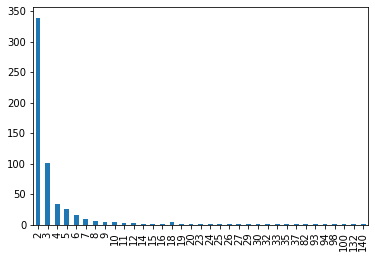

In [24]:
# plot the frequency distribution of food
fig, ax = plt.subplots()
food_unique.groupby('Venue')['Venue ID']\
    .agg(['count'])['count']\
    .value_counts()[1:]\
    .sort_index()\
    .plot(ax=ax, kind='bar')

In [25]:
# print sample of food sorted by frequency
food_unique.merge(food_unique.groupby('Venue')['Venue ID'].agg(['count']), on='Venue')\
    .groupby(['Venue', 'Venue Categories'])['count']\
    .first().sort_values(ascending=False)\
    .head(20)

Venue           Venue Categories     
Pret A Manger   Sandwich Place           140
Subway          Sandwich Place           132
McDonald's      Fast Food Restaurant     100
KFC             Fried Chicken Joint       98
                Fast Food Restaurant      98
Greggs          Bakery                    94
Nando's         Portuguese Restaurant     93
PizzaExpress    Pizza Place               82
Domino's Pizza  Pizza Place               82
GAIL's Bakery   Bakery                    37
itsu            Sushi Restaurant          37
Franco Manca    Pizza Place               35
Pizza Hut       Pizza Place               33
wagamama        Asian Restaurant          33
Leon            Fast Food Restaurant      32
                Restaurant                32
                Café                      32
Byron           Burger Joint              30
Paul            Bakery                    29
                Café                      29
Name: count, dtype: int64

#### Drinks

The Drinks group is a stranger outcome, as there are not as many clear chains.  Doing a little research reveals that **All Bar One**, **Slug and Lettuce** and **Executive Lounge Hilton** are definitely part of a chain, but many of the others have the same name as a coincidence.  Or due to the lack of creativity in pub names.

Consequently we won't be able to use this approach to easily identify whether a bar is a chain, so we'll need to exclude this feature from the list.

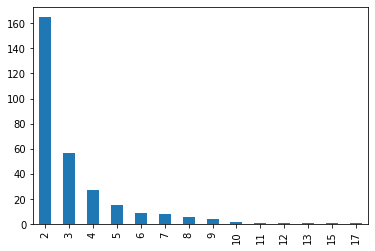

In [26]:
# plot the frequency distribution of drinks
fig, ax = plt.subplots()
drinks_unique.groupby('Venue')['Venue ID']\
    .agg(['count'])['count']\
    .value_counts()[1:]\
    .sort_index()\
    .plot(ax=ax, kind='bar')

In [27]:
# print sample of drinks sorted by frequency
drinks_unique.merge(drinks_unique.groupby('Venue')['Venue ID'].agg(['count']), on='Venue')\
    .groupby(['Venue', 'Venue Categories'])['count']\
    .first().sort_values(ascending=False)\
    .head(20)

Venue                    Venue Categories
All Bar One              Bar                 17
The Crown                Pub                 15
                         Gastropub           15
Slug & Lettuce           Bar                 13
Be At One                Bar                 12
                         Cocktail Bar        12
The White Hart           Gastropub           11
                         Pub                 11
                         Hotel               11
The Red Lion             Pub                 10
The George               Bar                 10
                         Pub                 10
Simmons Bar              Bar                  9
                         Cocktail Bar         9
Executive Lounge Hilton  Hotel Bar            9
The Royal Oak            Gastropub            9
                         Pub                  9
Simmons Bar              Pub                  9
The Victoria             Pub                  9
                         Gastropub            

In [28]:
# merge the counts from the unique records back into the full list for each of shops, coffee, food, drinks
shops_final = shops.merge(\
    shops_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
shops_final['Venue Frequency Sq'] = shops_final['Venue Frequency']**2

coffee_final = coffee.merge(\
    coffee_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
coffee_final['Venue Frequency Sq'] = coffee_final['Venue Frequency']**2

food_final = food.merge(\
    food_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
food_final['Venue Frequency Sq'] = food_final['Venue Frequency']**2

drinks_final = drinks.merge(\
    drinks_unique.groupby('Venue')['Venue ID']\
        .agg(['count'])\
        .sort_values('count', ascending=False)\
        .rename({'count': 'Venue Frequency'}, axis='columns')\
        .reset_index(), 
    on='Venue')
drinks_final['Venue Frequency Sq'] = drinks_final['Venue Frequency']**2

### 3.1.2. Hipster Factor

We'll establish some basic criteria for what qualifies as a hipster shop.  It will need to be one of a selected set of categories listed below, and it will need to have a 'Venue Frequency' less than 10 - this will exclude obvious chain stores (which can occur with Bookstores and Thift / Vintage Stores, while maintaining flexibility for independents of a certain size.

In [30]:
# hand-pick some hipster categories
hipster_cats = ['Bookstore','Thrift / Vintage Store','Market','Farmers Market','Arts & Crafts Store','Flea Market','Record Shop','Street Food Gathering','Beer Store','Organic Grocery','Antique Shop']

# pick out shops that are in the hipster categories, and that have a venue frequency less than or equal to 10
hipster_final = shops_final[(shops_final['Venue Categories'].isin(hipster_cats)) & (shops_final['Venue Frequency']<=10)]
hipster_cats

['Bookstore',
 'Thrift / Vintage Store',
 'Market',
 'Farmers Market',
 'Arts & Crafts Store',
 'Flea Market',
 'Record Shop',
 'Street Food Gathering',
 'Beer Store',
 'Organic Grocery',
 'Antique Shop']

In [31]:
# print out sample of hip venues sorted by frequency
hipster_final.groupby(['Latitude', 'Longitude', 'Placename'])['Venue ID']\
    .agg(['count'])\
    .reset_index()\
    .sort_values(by='count', ascending=False)\
    .rename({'count': 'Number of Hip Venues'}, axis='columns')\
    .head(10)

,Latitude,Longitude,Placename,Number of Hip Venues
178,51.5251,-0.0769,Shoreditch,32
123,51.5085,-0.1257,London,25
140,51.5134,-0.1234,Embankment,24
124,51.5085,-0.1249,Charing Cross,24
147,51.5142,-0.1247,Covent Garden,24
160,51.5175,-0.1204,Holborn,23
215,51.5431,-0.1499,Chalk Farm,22
168,51.5225,-0.0857,Bank,21
125,51.5095,-0.1958,Notting Hill Gate,20
210,51.5406,-0.1433,Camden Town,20


### 3.1.3.  Culture

Counting the number of venues by area that are "arts" or "sights" venues will give us a good measure of the cultural options.

Sample of "arts":

In [32]:
# print out sample of arts venues sorted by frequency 
arts.groupby(['Latitude', 'Longitude', 'Placename'])['Venue ID']\
    .agg(['count'])\
    .reset_index()\
    .sort_values(by='count', ascending=False)\
    .rename({'count': 'Number of Art Venues'}, axis='columns')\
    .head(10)

,Latitude,Longitude,Placename,Number of Art Venues
219,51.5134,-0.1234,Embankment,161
228,51.5144,-0.1354,Soho,157
200,51.5085,-0.1249,Charing Cross,154
199,51.5085,-0.1257,London,154
226,51.5142,-0.1247,Covent Garden,153
237,51.5166,-0.1308,Tottenham Court Road,146
231,51.5154,-0.1414,Oxford Circus,111
242,51.5175,-0.1204,Holborn,110
230,51.5148,-0.1461,Oxford Street,85
269,51.5268,-0.1333,Euston,79


## 3.2. Clustering

Our features of interest then should are:

1. number of shops 
2. number of coffee venues 
3. number of food venues
4. uniqueness of shops
5. uniqueness of coffee venues
6. uniqueness of food venues
7. number of hip venues
8. uniquenesss of hip venues
9. number of drinks venues
10. number of arts venues
11. number of sights

As a metric to reflect the uniqueness of a venue, we'll take the 'Venue Frequency' and square it, and take the average of this across all the venues within a given location.  We'll call this the Mean Frequency Squared (MFS for short).  A lower value means the shops in the location are more unique / independent, whereas a higher value will mean the shops are more likely to be chains.

We will then apply k-means clustering to the locations and their feature data, to discern patterns within the data and to identify locations that are most like each other.  Once this task is completed, we'll review the individual clusters and determine which is the cluster most interesting to us to open a shop, and look at possible next steps.

Our data (in advance of normalization) looks like this:


In [33]:
# build the metrics we're going to be clustering on
ldn_clusters = ldn[['Latitude', 'Longitude']].copy()

# add the shops count
ldn_clusters = ldn_clusters.merge(shops_final.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Shops Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the shops mean frequency squared
ldn_clusters = ldn_clusters.merge(shops_final.groupby(['Latitude', 'Longitude'])['Venue Frequency Sq'].agg(['mean']).rename({'mean': 'Shops MFS'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the coffee count
ldn_clusters = ldn_clusters.merge(coffee_final.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Coffee Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the coffee mean frequency squared
ldn_clusters = ldn_clusters.merge(coffee_final.groupby(['Latitude', 'Longitude'])['Venue Frequency Sq'].agg(['mean']).rename({'mean': 'Coffee MFS'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the food count
ldn_clusters = ldn_clusters.merge(food_final.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Food Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the food mean frequency squared
ldn_clusters = ldn_clusters.merge(food_final.groupby(['Latitude', 'Longitude'])['Venue Frequency Sq'].agg(['mean']).rename({'mean': 'Food MFS'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the drinks count
ldn_clusters = ldn_clusters.merge(drinks_final.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Drinks Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the arts count
ldn_clusters = ldn_clusters.merge(arts.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Arts Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the sights count
ldn_clusters = ldn_clusters.merge(sights.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Sights Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the hipster count
ldn_clusters = ldn_clusters.merge(hipster_final.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Hipster Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# add the hipster mean frequency squared
ldn_clusters = ldn_clusters.merge(hipster_final.groupby(['Latitude', 'Longitude'])['Venue Frequency Sq'].agg(['mean']).rename({'mean': 'Hipster MFS'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

# fill in all the empty spaces with 0.0
ldn_clusters.fillna(0.0, inplace=True)
ldn_clusters.head()

,Latitude,Longitude,Shops Count,Shops MFS,Coffee Count,Coffee MFS,Food Count,Food MFS,Drinks Count,Arts Count,Sights Count,Hipster Count,Hipster MFS
0,51.3133,0.0343,7,17111.428571,4.0,29757.0,4.0,1.000000,2.0,2.0,4,0.0,0.0
1,51.3148,-0.1570,3,1.000000,0.0,0.0,4.0,1.750000,2.0,2.0,6,0.0,0.0
2,51.3192,0.0712,4,1.000000,0.0,0.0,0.0,0.000000,1.0,1.0,4,0.0,0.0
3,51.3200,-0.1409,12,10634.166667,5.0,4682.6,11.0,6.363636,4.0,4.0,8,0.0,0.0
4,51.3264,-0.1011,2,10082.500000,0.0,0.0,10.0,1.000000,2.0,4.0,4,0.0,0.0


When we run k-means clustering against the data, we trial several different cluster numbers and review the resulting metrics to choose a good value for k.

As we review the sum of square differences, there's not a sufficiently clear "elbow" to decide the value of k.  Instead we use the silhouette score as a different metric and this gives us a bit more clarity.

Remarkably 2 metrics for k=5 and k=7 are quite close to each other, and we choose the slightly higher one rather than the one with the best score - the differnce is marginal and the outcome is more finely tuned to our purposes.

In [34]:
# normalize clustering data with the standard scalar
ldn_clustering = StandardScaler().fit_transform(ldn_clusters.drop(['Latitude', 'Longitude'], axis='columns'))

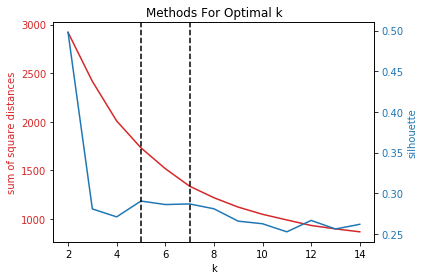

In [37]:
from sklearn.metrics import silhouette_score

# run through all the values of k and calculate the inertia and silhouette score for them
elbow = []
sil =[]
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(ldn_clustering)
    elbow.append(km.inertia_)
    labels = km.labels_
    sil.append(silhouette_score(ldn_clustering, labels, metric='euclidean'))

    
fig, ax1 = plt.subplots()

# plot the inertia against k
color = 'tab:red'
ax1.set_title('Methods For Optimal k')
ax1.set_xlabel('k')
ax1.set_ylabel('sum of square distances', color=color)
ax1.plot(K, elbow, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

# plot the silhouette against k
color = 'tab:blue'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(K, sil, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# add some vertical lines on k=5 and 7
ax2.axvline(x=5, color='black', ls='--')
ax2.axvline(x=7, color='black', ls='--')

plt.show()


We then run the clustering for the value of k=7, and produce a map of London overlaid with different locations color-coded with their cluster.  Below follows a review of the individual clusters and their prospective value to us.

In [38]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ldn_clustering)

# add clustering labels
ldn_clusters['Cluster Labels'] = kmeans.labels_

# merge details back in
ldn_final = ldn_clusters.merge(ldn, on=['Latitude', 'Longitude'])


In [39]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ldn_final['Latitude'], ldn_final['Longitude'], ldn_final['Placename'], ldn_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
cluster_cols = ldn_final.columns[ldn_final.columns.str.contains('Count') | ldn_final.columns.str.contains('MFS')].to_list()

def print_cluster(i):
    print('### cluster number: {} has {} locations:'.format(i, ldn_final[ldn_final['Cluster Labels']==i].count()[0]))
    print(ldn_final[ldn_final['Cluster Labels']==i][cluster_cols].mean())
    print()
    print('# sample locations:')
    print(ldn_final[ldn_final['Cluster Labels']==i]['Placename'][0:10])
    print()


#### Cluster 0

Our first cluster is the second worst candidate to open a shop.  It's the second least hip, and although it has more shops and these are slightly more independent, the food and coffee options are the most likely to be chains.  This is likely to be a suburban area with slightly more activity, but an unwise place to open a hip store.

In [41]:
print_cluster(0)

### cluster number: 0 has 98 locations:
Shops Count         25.489796
Shops MFS         6196.007732
Coffee Count         7.122449
Coffee MFS       34730.426611
Food Count          17.336735
Food MFS          2333.200831
Drinks Count         6.234694
Arts Count           2.765306
Sights Count        30.428571
Hipster Count        0.520408
Hipster MFS          0.945578
dtype: float64

# sample locations:
5          Sanderstead
7               Purley
20    South Beddington
25           Orpington
28      Worcester Park
29            Tolworth
30              Sutton
31             Croydon
45             Bromley
55         Chislehurst
Name: Placename, dtype: object



#### Cluster 1

This cluster is the most likely candidate for us to open a shop.  It has a reasonable cultural profile, a good number of coffee, food places and shops with independence.  It also has decent number of hipster options with a good score.

In [42]:
print_cluster(1)

### cluster number: 1 has 82 locations:
Shops Count        70.195122
Shops MFS        7039.706114
Coffee Count       45.902439
Coffee MFS       9282.302691
Food Count         98.914634
Food MFS          865.451266
Drinks Count       43.634146
Arts Count         13.865854
Sights Count      142.012195
Hipster Count       6.951220
Hipster MFS         4.253009
dtype: float64

# sample locations:
49     Kingston upon Thames
60          South Wimbledon
103              Tulse Hill
105    Richmond upon Thames
107                Richmond
110                 Lambeth
111                 Clapham
114        Clapham Junction
117                 Brixton
118           Clapham North
Name: Placename, dtype: object



#### Cluster 2

This cluster is one of the weaker candidate for opening a shop.  It has few shops, coffee and food options, and culturally it's poor compared to some of the stronger clusters.

In [43]:
print_cluster(2)

### cluster number: 2 has 162 locations:
Shops Count        19.882716
Shops MFS        6009.353817
Coffee Count        9.049383
Coffee MFS       8100.492138
Food Count         21.129630
Food MFS          537.102504
Drinks Count        8.425926
Arts Count          3.283951
Sights Count       34.839506
Hipster Count       1.296296
Hipster MFS         1.149544
dtype: float64

# sample locations:
1          Hooley
2          Cudham
3        Coulsdon
4          Kenley
6           Downe
8          Sutton
10      Addington
13     Chelsfield
14    Farnborough
15         Keston
Name: Placename, dtype: object



#### Cluster 3

This cluster is a step up from our three weakest.  It has a small amount of hip and cultural activity, a reasonable number of shops with decent independence, but it's the second most likely to have coffee and food options that are chains.  Based purely on our metrics this is a slightly more urbanized suburbia, and it's telling that the weakest clusters for our purposes are all around the edge of London.

In [44]:
print_cluster(3)

### cluster number: 3 has 22 locations:
Shops Count         57.636364
Shops MFS         5028.117808
Coffee Count        21.772727
Coffee MFS       13272.275323
Food Count          49.136364
Food MFS          1140.840503
Drinks Count        17.454545
Arts Count           5.772727
Sights Count        74.500000
Hipster Count        4.681818
Hipster MFS         30.447658
dtype: float64

# sample locations:
61             Wimbledon
66                Merton
84           Southfields
88     Wandsworth Common
93             West Hill
101        North Dulwich
106           Wandsworth
108               Putney
115             Lewisham
116           Blackheath
Name: Placename, dtype: object



#### Cluster 4

This is the beating heart of cultural activity and hipness in London, by our metrics - although it does lose a slight amount on the fact that the hipness has some chain stores.  It has a massive number of shops, coffee and food options, with a mix of independent and chain options. Because of the large number of shops however the competition (also rent and business rates) would be very high, making this not a preferred location for our shop opening.

In [45]:
print_cluster(4)

### cluster number: 4 has 9 locations:
Shops Count       191.000000
Shops MFS        2995.533499
Coffee Count      190.555556
Coffee MFS       5021.251725
Food Count        249.111111
Food MFS          323.768650
Drinks Count      227.444444
Arts Count        136.777778
Sights Count      226.222222
Hipster Count      19.777778
Hipster MFS         7.589503
dtype: float64

# sample locations:
215                  London
216           Charing Cross
235              Embankment
242           Covent Garden
244                    Soho
246           Oxford Street
248           Oxford Circus
254    Tottenham Court Road
259                 Holborn
Name: Placename, dtype: object



#### Cluster 5

This cluster is the worst candidate for us to open a shop.  It's the least hip, has no activity to draw any kind of footfall.  The few existing shops are all chains, although the coffee and food venues are more independent.  Looking at the map representation, they are almost entirely outside of central London, so this is not surprising - the shops will more likely than not be grocery stores, and restaurants will be locally owned.  This is also the least culturally active location.

In [46]:
print_cluster(5)

### cluster number: 5 has 48 locations:
Shops Count         10.187500
Shops MFS        20014.968975
Coffee Count         5.270833
Coffee MFS        8974.225721
Food Count          11.520833
Food MFS           961.352942
Drinks Count         5.104167
Arts Count           2.312500
Sights Count        19.937500
Hipster Count        0.187500
Hipster MFS          0.187500
dtype: float64

# sample locations:
0          Biggin Hill
9           Wallington
11             Belmont
12               Cheam
16         Chessington
17      Malden Rushett
21                Hook
35    Morden Hall Park
36            Woodside
40       South Norwood
Name: Placename, dtype: object



#### Cluster 6

This is one of the better clusters on our metrics count.  It has a lot of food and drink options, and the former are quite independent.  The coffee options are also significant, although there are quite a lot of chains present.  The shops are significant but they are the second worst among all the clusters for independence.  If you were looking to open a shop that was not so focused on uniqueness, you would consider this cluster as a viable option.

In [47]:
print_cluster(6)

### cluster number: 6 has 47 locations:
Shops Count        126.085106
Shops MFS         8102.034243
Coffee Count       122.510638
Coffee MFS       10992.274526
Food Count         205.191489
Food MFS           730.231981
Drinks Count       138.808511
Arts Count          47.212766
Sights Count       221.319149
Hipster Count       12.659574
Hipster MFS          5.348187
dtype: float64

# sample locations:
179      South Kensington
183              Victoria
188                London
190    Westminster Bridge
194            Marylebone
195           Westminster
196             Southwark
206            South Bank
207             Southwark
209              Waterloo
Name: Placename, dtype: object



In [49]:
# build the full list of all venues from each category group
all = pd.DataFrame()
all = all.append([jewels_unique, shops_unique, coffee_unique, food_unique, drinks_unique, arts_unique, sights_unique])

In [51]:
# de-dupe the records so it's only unique venues
all_unique = all.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first')

## 4. Results

In [52]:
# merge in and count the total number of jewelry shops
ldn_final = ldn_final.merge(all_unique[all_unique['Venue Categories'].str.contains('Jewelry')]\
    .groupby(['Latitude','Longitude'])['Venue ID']\
    .agg(['count'])\
    .rename({'count': 'Jewel Count'}, axis='columns')\
    .reset_index(), on=['Latitude','Longitude'], how='left')

In [53]:
# fill in the nulls with 0.0
ldn_final.fillna(0.0, inplace=True)

# get the ratio of jewelry shops to total shops
ldn_final['Jewel/Shop Density'] = ldn_final['Jewel Count']/ldn_final['Shops Count']

Based on our evaluation, Cluster 1 is the most likely candidate for a place to open a shop.  

It's worth refining this a bit more to break down where to start our search.  

#### The "Low Competition" Approach

One possible way to look at this is to see whether there are other Jewelry shops in the area - look for places with less or no competition but which still have a good amount of other cool shops.

Given that approach, our top 5 options are:

In [54]:
# sort by low competition
ldn_final[ldn_final['Cluster Labels']==1].sort_values(by=['Jewel/Shop Density', 'Hipster Count', 'Hipster MFS'], ascending=[True, False, True])[['Latitude', 'Longitude', 'Placename', 'Postalcode', 'Hipster Count', 'Hipster MFS', 'Jewel/Shop Density']].head(5)

,Latitude,Longitude,Placename,Postalcode,Hipster Count,Hipster MFS,Jewel/Shop Density
338,51.5480,-0.0629,Shacklewell,E8,18.0,7.111111,0.0
288,51.5272,-0.0611,Bethnal Green,E2,15.0,2.066667,0.0
214,51.5075,-0.2050,Ladbroke Grove,W11,13.0,4.307692,0.0
173,51.4911,-0.1493,Belgravia,SW1,12.0,1.000000,0.0
103,51.4548,-0.1158,Tulse Hill,SW2,11.0,1.000000,0.0


#### The "High Footfall" Approach

One other approach might be to worry less about the competition and focus on the total number of venues in the area.  This strategy would assume that your goal is footfall, implying that more things to do in the area means more people coming your way.

Given that approach, our top 5 options are:

In [55]:
# build the total count of venues
ldn_final = ldn_final.merge(all_unique\
    .groupby(['Latitude','Longitude'])['Venue ID']\
    .agg(['count'])\
    .rename({'count': 'Total Count'}, axis='columns')\
    .reset_index(), on=['Latitude','Longitude'], how='left')

In [56]:
# sort by total count
ldn_final[ldn_final['Cluster Labels']==1].sort_values(by=['Total Count'], ascending=[False])[['Latitude', 'Longitude', 'Placename', 'Postalcode', 'Total Count']].head(5)

,Latitude,Longitude,Placename,Postalcode,Total Count
49,51.4126,-0.2974,Kingston upon Thames,KT1,286.0
312,51.5362,-0.1030,Islington,"EC1P,EC4P,EC50,N1,N1C,N1P,N7",275.0
210,51.5050,-0.2211,Western Avenue,W12,241.0
202,51.5015,-0.1619,Knightsbridge,SW1,223.0
162,51.4870,-0.1910,West Brompton,SW5,219.0


#### The "Super Hipster" Approach

One final approach might be to just aim for the hippest place you can find, and not worry about anything else.  So focus on the number of hip shops and their independence.

Given that approach, our top 5 options are:

In [57]:
# sort by most hip places
ldn_final[ldn_final['Cluster Labels']==1].sort_values(by=['Hipster Count', 'Hipster MFS'], ascending=[False, True])[['Latitude', 'Longitude', 'Placename', 'Postalcode', 'Hipster Count', 'Hipster MFS', 'Jewel/Shop Density']].head(5)

,Latitude,Longitude,Placename,Postalcode,Hipster Count,Hipster MFS,Jewel/Shop Density
309,51.5344,-0.0694,Shoreditch,N1,18.0,1.166667,0.072464
338,51.5480,-0.0629,Shacklewell,E8,18.0,7.111111,0.000000
226,51.5115,-0.2059,Notting Hill,W11,16.0,3.687500,0.027027
288,51.5272,-0.0611,Bethnal Green,E2,15.0,2.066667,0.000000
292,51.5279,-0.1072,Finsbury,EC1,14.0,8.857143,0.011364


## 5. Discussion

This evaluation was done within the constraints of the Foursquare API and the level of free access available.  A more complete/mature approach would be to retrieve ratings and price for venues, and to use that to identify the affluence of the specific neighbourhood based on that.  We might find that even though an area is moderately populated with shops, these are much more high end.  And conversely we may find that an area that has a large number of shops with a high amount of independence is because they are in a poorer area, and therefore less likely to be interested in buying jewellery.

The Foursquare API also had a limited set returned for venues in a particular area, which was not always consistent.  Radial searches might return the same number of results even though the radius was increased.  There was also a fair amount of overlap on locations, as well as some areas on the map that had limited coverage.  More time could be spent on selecting the locations to ensure full map coverage, but also to align with consumer behavior such as focusing on a known set of shopping areas.

We could also retrieve demographic data from a different source such as the UK Census.  At the time of this evaluation the most recent data was for 2011 and therefore deemed to be too old to be relevant, but new data will be released within the next 2 years and will be much more up-to-date.  

There may also be more useful econographic data that could inform a stronger model.  This data often requires a fee, but a student license might be available for the purposes of this study.

Commercial and residential property prices by area would be an incredibly powerful tool, as it would allow for a clear filter of what would be an acceptable price to pay and what a target turnover for a shop would need to be if it opened.

Finally, further exploratory work could be done to build useful features, with the data we have available.  A more careful study of the categories available in the given larger groups might mean we exclude categories that are not interesting or useful to the study, or score specific categories higher than others based on their importance.


## 6. Conclusion

We were able to successfully build some metrics of interest to an independent jewelry shop, and use k-means clustering to identify locations in Greater London that are good targets for this kind of business.

Ironically, the original first location for the shop is in 'Shoreditch', which was rated the hippest location in Cluster 1.

So then... Data Science is hip.